In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grdspc
import seaborn as sns
import random as rnd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.model_selection import GridSearchCV as GSCV, cross_val_score as CVS

### Import Data

In [2]:
SbrBkTrain = pd.read_csv('train.csv').filter(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'price_doc', 'timestamp'])
SbrBkTest = pd.read_csv('test.csv').filter(['id', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'product_type', 'sub_area', 'timestamp'])

# converting timestamp variable to be of datetime type
SbrBkTrain.timestamp = pd.to_datetime(SbrBkTrain.timestamp)
SbrBkTest.timestamp = pd.to_datetime(SbrBkTest.timestamp)

### 2. Data Cleaning
##### - Exploratory Data Analysis (EDA):
* Calculate descriptive statistics (mean, median, standard deviation, min, max) for numerical features

In [3]:
SbrBkTrain[['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'timestamp', 'price_doc']].describe().rename(index = {'mean': 'Mean', '50%': 'Median', 'std': 'Standard Deviation', 'min': 'Minimum', 'max': 'Maximum'}).loc[['Mean', 'Median', 'Standard Deviation', 'Minimum', 'Maximum'],]

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,timestamp,price_doc
Mean,54.214269,34.403271,7.670803,12.558974,3.068057e+03,1.909804,6.399301,2013-12-21 16:45:41.911982080,7.123035e+06
Median,49.000000,30.000000,6.500000,12.000000,1.979000e+03,2.000000,6.000000,2014-02-19 00:00:00,6.274411e+06
Standard Deviation,38.031487,52.285733,5.319989,6.756550,1.543878e+05,0.851805,28.265979,NaN,4.780111e+06
Minimum,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2011-08-20 00:00:00,1.000000e+05
Maximum,5326.000000,7478.000000,77.000000,117.000000,2.005201e+07,19.000000,2014.000000,2015-06-30 00:00:00,1.111111e+08


In [4]:
SbrBkTest[['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'timestamp']].describe().rename(index = {'mean': 'Mean', '50%': 'Median', 'std': 'Standard Deviation', 'min': 'Minimum', 'max': 'Maximum'}).loc[['Mean', 'Median', 'Standard Deviation', 'Minimum', 'Maximum'],]

,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,timestamp
Mean,53.701164,32.660037,7.652571,12.591099,1820.888099,1.876403,6.938662,2015-12-26 06:17:00.516836096
Median,50.410000,30.400000,7.000000,14.000000,1982.000000,2.000000,7.000000,2016-01-14 00:00:00
Standard Deviation,20.104320,22.737855,5.099418,6.659291,552.993964,0.835665,25.579688,NaN
Minimum,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2015-07-01 00:00:00
Maximum,403.000000,869.000000,41.000000,48.000000,2019.000000,19.000000,1968.000000,2016-05-30 00:00:00


* Examine frequency distributions of categorical features.

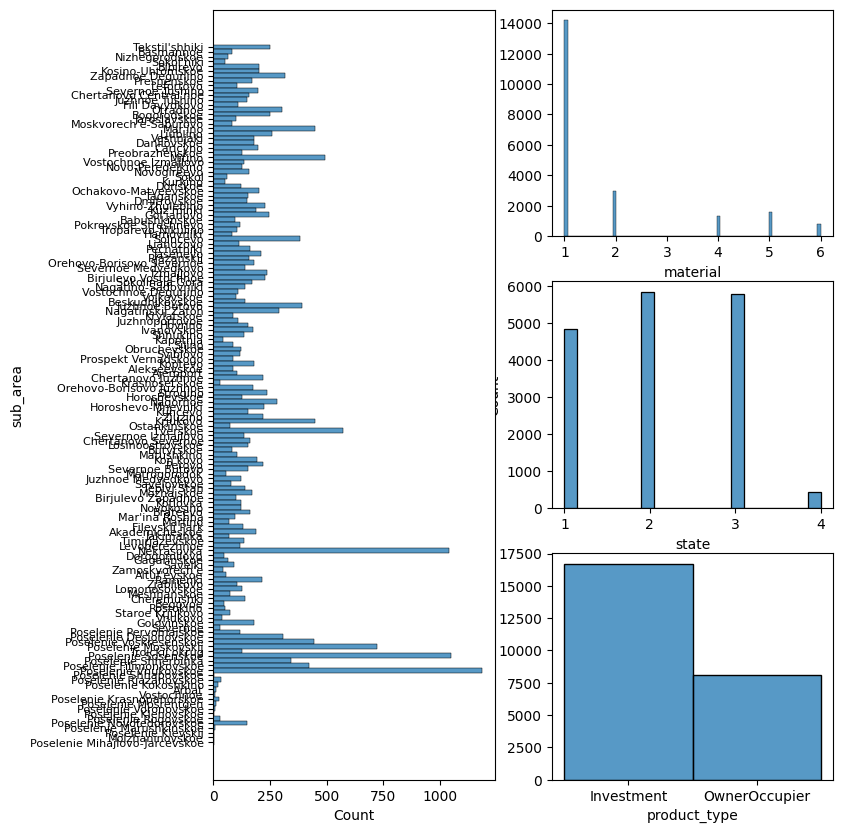

In [43]:
fig = plt.figure(figsize=(16, 20))

gs = grdspc.GridSpec(3, 2)

ax = [None] * 4

ax[0] = fig.add_subplot(gs[0, 1])
ax[1] = fig.add_subplot(gs[1, 1])
ax[2] = fig.add_subplot(gs[2, 1])
ax[3] = fig.add_subplot(gs[:, 0])

sns.histplot(SbrBkTrain.material, ax=ax[0])
sns.histplot(SbrBkTrain.state, ax=ax[1])
sns.histplot(SbrBkTrain.product_type, ax=ax[2])
sns.histplot(data = SbrBkTrain, y = 'sub_area', ax=ax[3])

ax[3].tick_params(axis='y', labelsize=8)

plt.show()

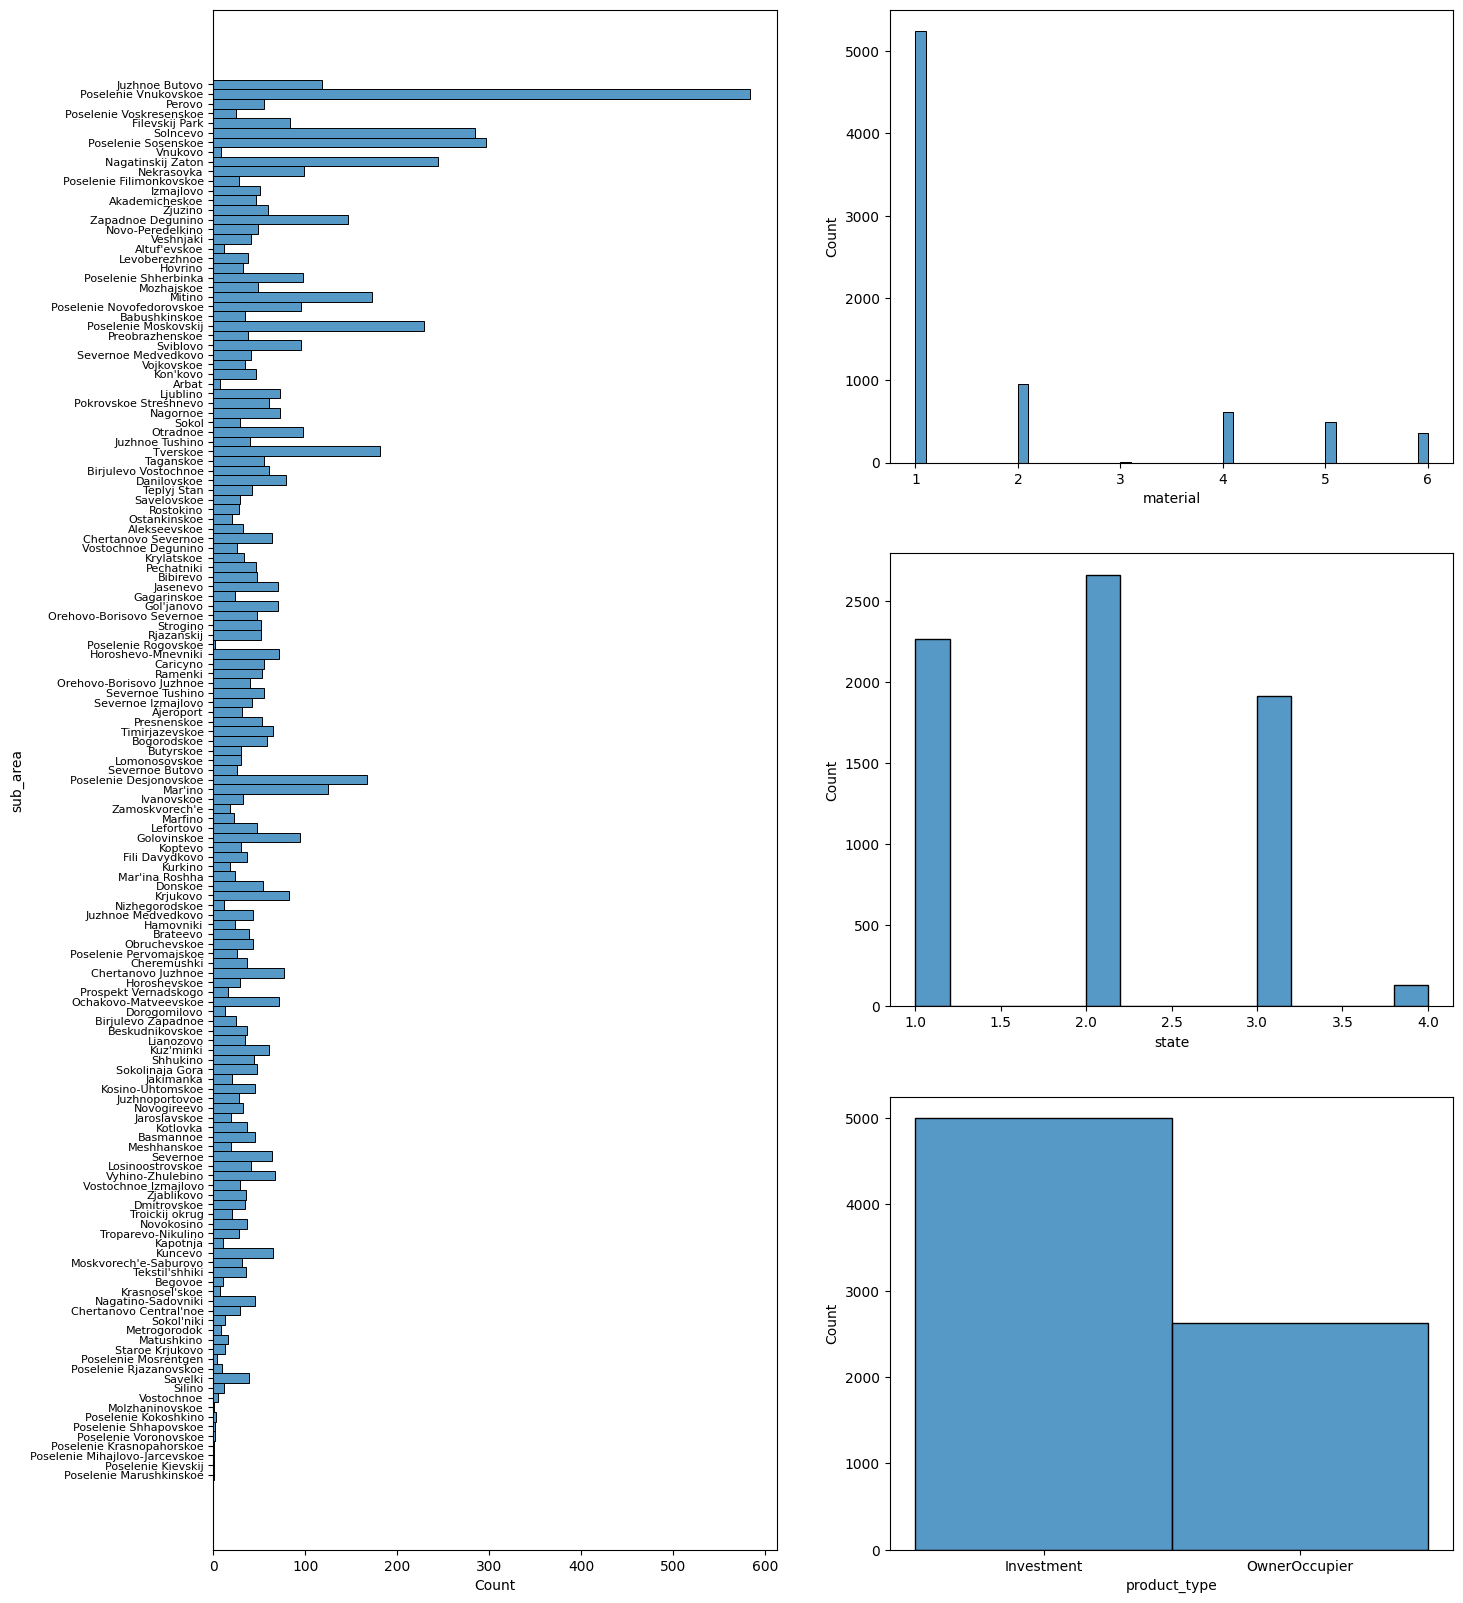

In [6]:
fig = plt.figure(figsize=(16, 20))

gs = grdspc.GridSpec(3, 2)

ax = [None] * 4

ax[0] = fig.add_subplot(gs[0, 1])
ax[1] = fig.add_subplot(gs[1, 1])
ax[2] = fig.add_subplot(gs[2, 1])
ax[3] = fig.add_subplot(gs[:, 0])

sns.histplot(SbrBkTest.material, ax=ax[0])
sns.histplot(SbrBkTest.state, ax=ax[1])
sns.histplot(SbrBkTest.product_type, ax=ax[2])
sns.histplot(data = SbrBkTest, y = 'sub_area', ax=ax[3])

ax[3].tick_params(axis='y', labelsize=8)

plt.show()

* Generate visualizations (histograms, boxplots, scatterplots) to uncover patterns and potential anomalies.

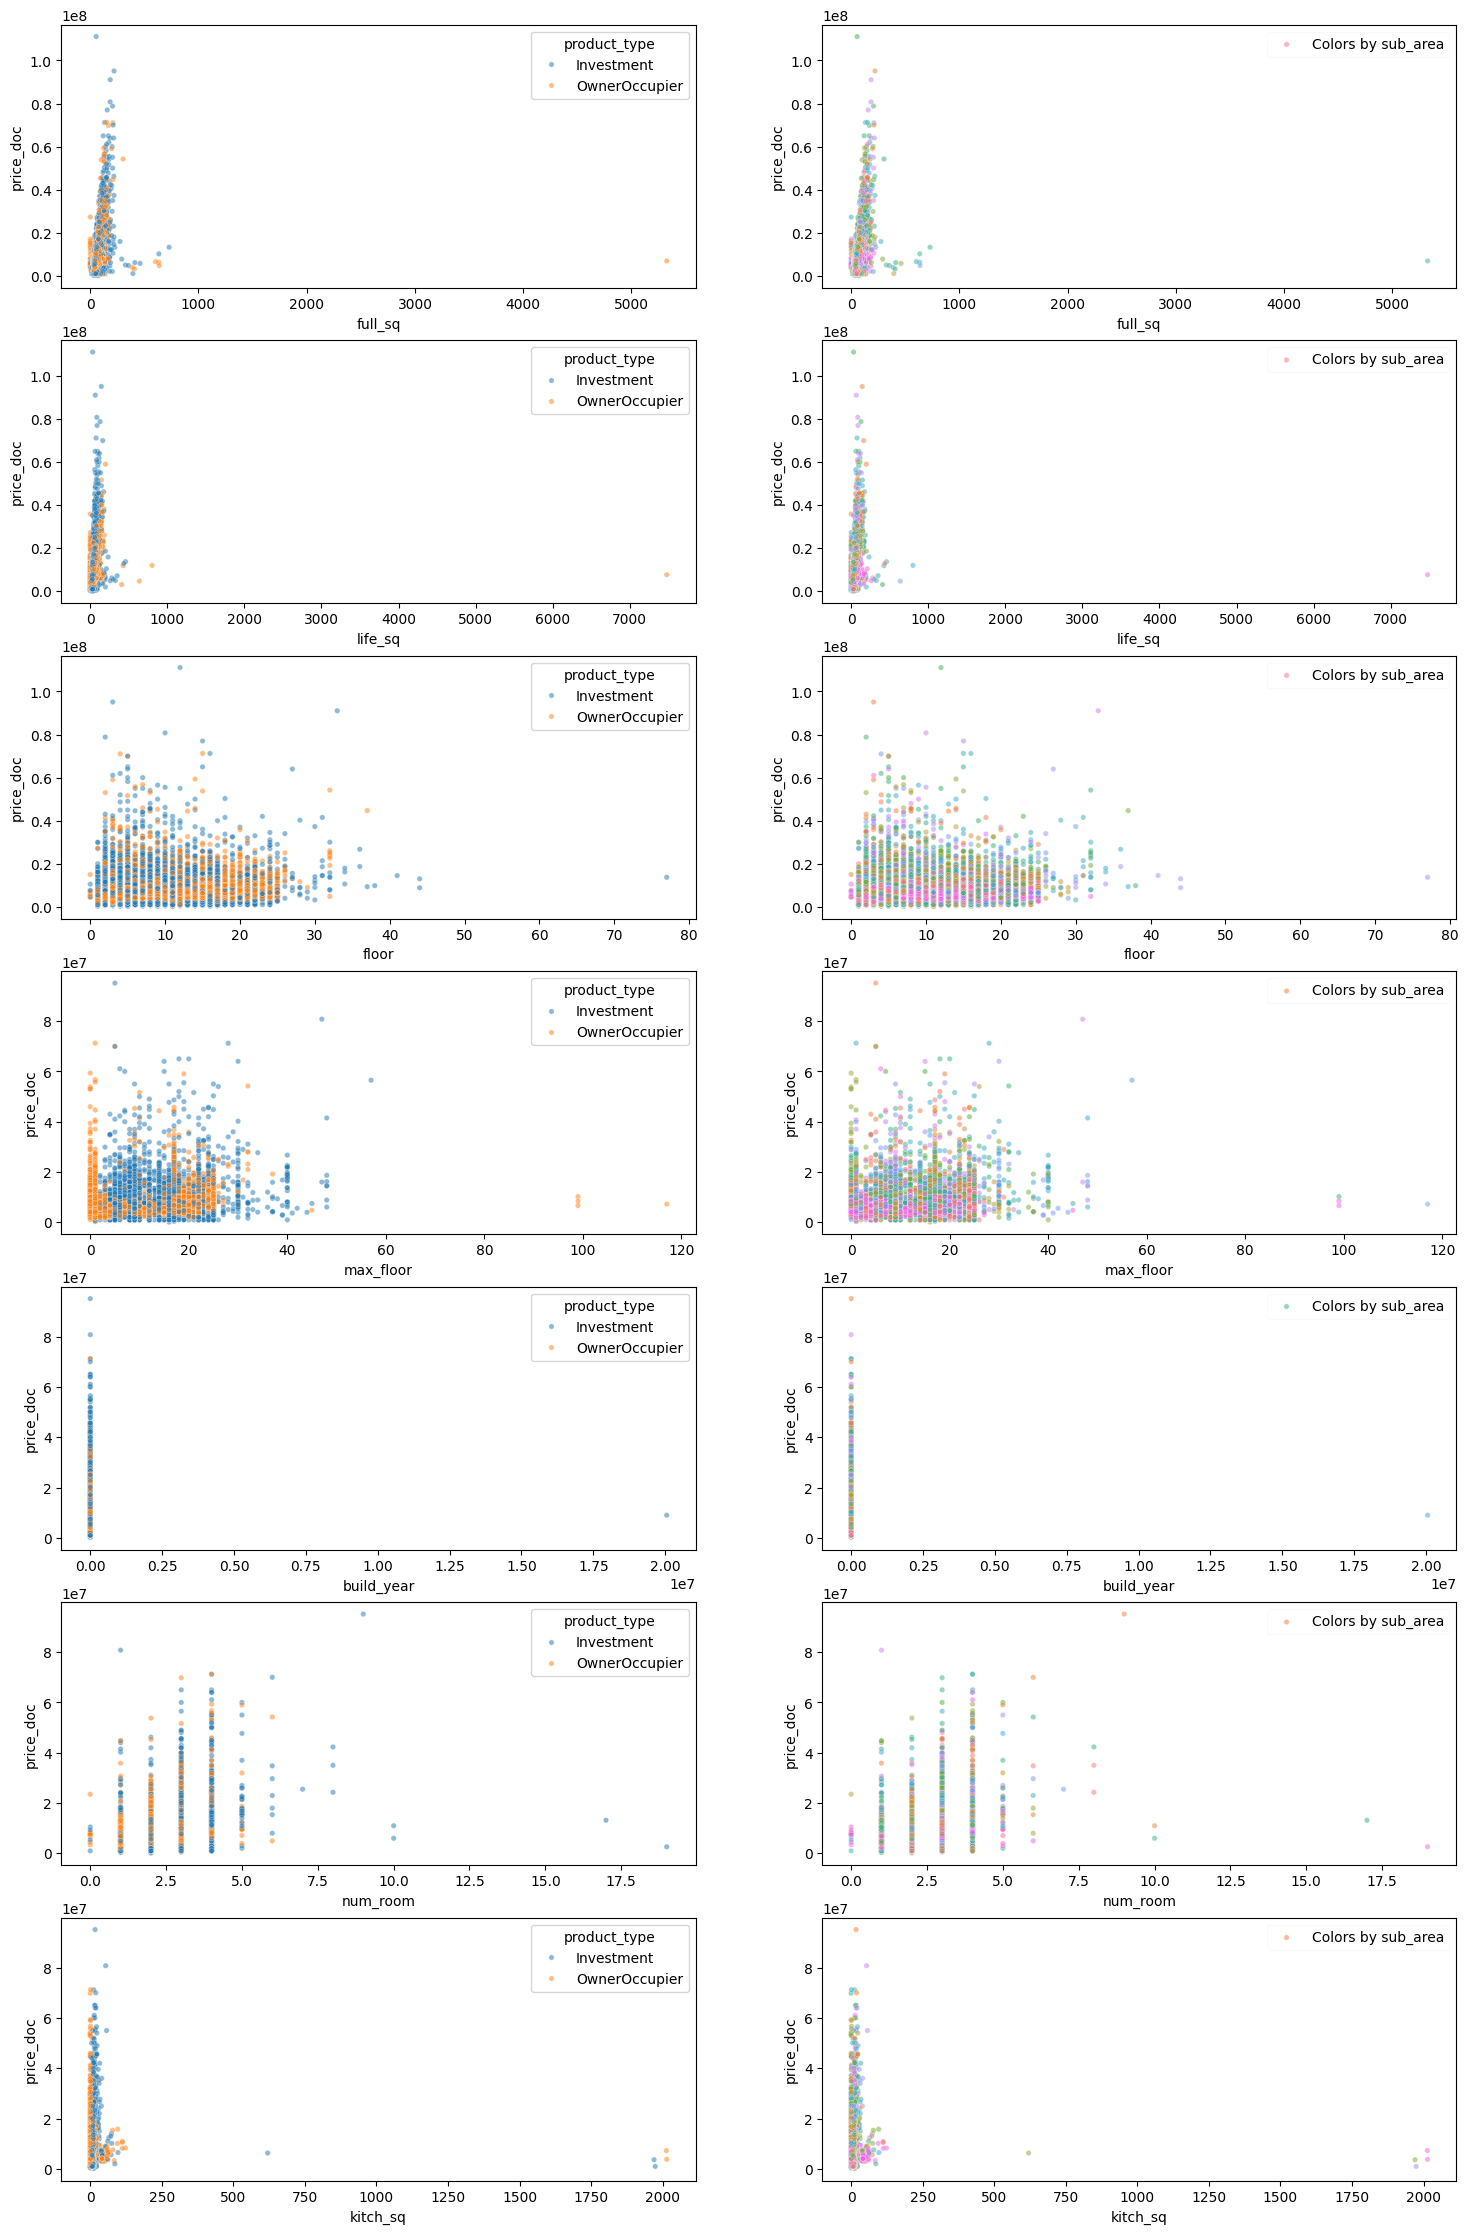

In [7]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(7, 2, figsize=(18, 28))

sns.scatterplot(SbrBkTrain, x = 'full_sq', y = 'price_doc', hue = 'product_type', ax = ax[0, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'full_sq', y = 'price_doc', hue = 'sub_area', ax = ax[0, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'life_sq', y = 'price_doc', hue = 'product_type', ax = ax[1, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'life_sq', y = 'price_doc', hue = 'sub_area', ax = ax[1, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'floor', y = 'price_doc', hue = 'product_type', ax = ax[2, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'floor', y = 'price_doc', hue = 'sub_area', ax = ax[2, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'max_floor', y = 'price_doc', hue = 'product_type', ax = ax[3, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'max_floor', y = 'price_doc', hue = 'sub_area', ax = ax[3, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'build_year', y = 'price_doc', hue = 'product_type', ax = ax[4, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'build_year', y = 'price_doc', hue = 'sub_area', ax = ax[4, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'num_room', y = 'price_doc', hue = 'product_type', ax = ax[5, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'num_room', y = 'price_doc', hue = 'sub_area', ax = ax[5, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'kitch_sq', y = 'price_doc', hue = 'product_type', ax = ax[6, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'kitch_sq', y = 'price_doc', hue = 'sub_area', ax = ax[6, 1], s = 15, alpha = 0.5)
ax[0, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[1, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[2, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[3, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[4, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[5, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[6, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')

fig.show()  

Before i handle missing values, i decided to take care of all the illogical values within the data and in the same time some of the outliers

Handling illogical values

Train dataset

In [8]:
warnings.filterwarnings('ignore')

# full_sq should be a value between 7 and 500 from my observation
SbrBkTrain.full_sq[SbrBkTrain.full_sq < 7] = np.nan
SbrBkTrain.full_sq[SbrBkTrain.full_sq > 500] = np.nan
# life_sq should be a value between 7 and 300 from my observation
SbrBkTrain.life_sq[SbrBkTrain.life_sq < 7] = np.nan
SbrBkTrain.life_sq[SbrBkTrain.life_sq > 300] = np.nan
# floor should not be a value above 40 from my observation
SbrBkTrain.floor[SbrBkTrain.floor > 40] = np.nan
# max_floor should not be a value above 50 from my observation
SbrBkTrain.max_floor[SbrBkTrain.max_floor > 50] = np.nan
# max_floor should not be a value below the value of floor in the same row
SbrBkTrain.max_floor[SbrBkTrain.max_floor < SbrBkTrain.floor] = np.nan
# build_year should not be before 1800 and above 2020 from my observation
SbrBkTrain.build_year[SbrBkTrain.build_year < 1800] = np.nan 
SbrBkTrain.build_year[SbrBkTrain.build_year > 2020] = np.nan
# num_room should be a value between 1 and 12 from my observation
SbrBkTrain.num_room[SbrBkTrain.num_room < 1] = np.nan
SbrBkTrain.num_room[SbrBkTrain.num_room > 12] = np.nan
# kitch_sq should not be a value below 2 and above 250 from my observation
SbrBkTrain.kitch_sq[SbrBkTrain.kitch_sq < 2] = np.nan
SbrBkTrain.kitch_sq[SbrBkTrain.kitch_sq > 250] = np.nan
# full_sq should not be a value below life_sq in the same row
SbrBkTrain.life_sq[SbrBkTrain.life_sq > SbrBkTrain.full_sq] = np.nan
# full_sq should not be a value below kitch_sq in the same row
SbrBkTrain.kitch_sq[SbrBkTrain.full_sq < SbrBkTrain.kitch_sq] = np.nan
# kitch_sq part of full_sq should not be above life_sq part of full_sq in the same row, as long as full_sq is greater than the sum of life_sq and kitch_sq
SbrBkTrain.kitch_sq[(SbrBkTrain.kitch_sq / SbrBkTrain.full_sq > SbrBkTrain.life_sq / SbrBkTrain.full_sq) & (SbrBkTrain.full_sq >= SbrBkTrain.life_sq + SbrBkTrain.kitch_sq)] = np.nan
# full_sq should not be a value below the sum of life_sq and kitch_sq in the same row
SbrBkTrain.life_sq[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq] = SbrBkTrain.full_sq[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq] - SbrBkTrain.kitch_sq[SbrBkTrain.full_sq < SbrBkTrain.life_sq + SbrBkTrain.kitch_sq]
# fixing the state values that are incorrect due to misstyping
SbrBkTrain.state[SbrBkTrain.state > 4] = SbrBkTrain.state[SbrBkTrain.state > 4] // 10

Test dataset

In [9]:
warnings.filterwarnings('ignore')

# full_sq should be a value between 7 and 500 from my observation
SbrBkTest.full_sq[SbrBkTest.full_sq < 7] = np.nan
SbrBkTest.full_sq[SbrBkTest.full_sq > 500] = np.nan
# life_sq should be a value between 7 and 300 from my observation
SbrBkTest.life_sq[SbrBkTest.life_sq < 7] = np.nan
SbrBkTest.life_sq[SbrBkTest.life_sq > 300] = np.nan
# floor should not be a value above 40 from my observation
SbrBkTest.floor[SbrBkTest.floor > 40] = np.nan
# max_floor should not be a value above 50 from my observation
SbrBkTest.max_floor[SbrBkTest.max_floor > 50] = np.nan
# max_floor should not be a value below the value of floor in the same row
SbrBkTest.max_floor[SbrBkTest.max_floor < SbrBkTest.floor] = np.nan
# build_year should not be before 1800 and above 2020 from my observation
SbrBkTest.build_year[SbrBkTest.build_year < 1800] = np.nan 
SbrBkTest.build_year[SbrBkTest.build_year > 2020] = np.nan
# num_room should be a value between 1 and 12 from my observation
SbrBkTest.num_room[SbrBkTest.num_room < 1] = np.nan
SbrBkTest.num_room[SbrBkTest.num_room > 12] = np.nan
# kitch_sq should not be a value below 2 and above 250 from my observation
# SbrBkTest.kitch_sq[SbrBkTest.kitch_sq < 2] = np.nan
# SbrBkTest.kitch_sq[SbrBkTest.kitch_sq > 250] = np.nan
# full_sq should not be a value below life_sq in the same row
SbrBkTest.life_sq[SbrBkTest.life_sq > SbrBkTest.full_sq] = np.nan
# full_sq should not be a value below kitch_sq in the same row
SbrBkTest.kitch_sq[SbrBkTest.full_sq < SbrBkTest.kitch_sq] = np.nan
# kitch_sq part of full_sq should not be above life_sq part of full_sq in the same row, as long as full_sq is greater than the sum of life_sq and kitch_sq
SbrBkTest.kitch_sq[(SbrBkTest.kitch_sq / SbrBkTest.full_sq > SbrBkTest.life_sq / SbrBkTest.full_sq) & (SbrBkTest.full_sq >= SbrBkTest.life_sq + SbrBkTest.kitch_sq)] = np.nan
# full_sq should not be a value below the sum of life_sq and kitch_sq in the same row
SbrBkTest.life_sq[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq] = SbrBkTest.full_sq[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq] - SbrBkTest.kitch_sq[SbrBkTest.full_sq < SbrBkTest.life_sq + SbrBkTest.kitch_sq]
# fixing the state values that are incorrect due to misstyping
SbrBkTest.state[SbrBkTest.state > 4] = SbrBkTest.state[SbrBkTest.state > 4] // 10

after that i can now see better on the same graphs from before

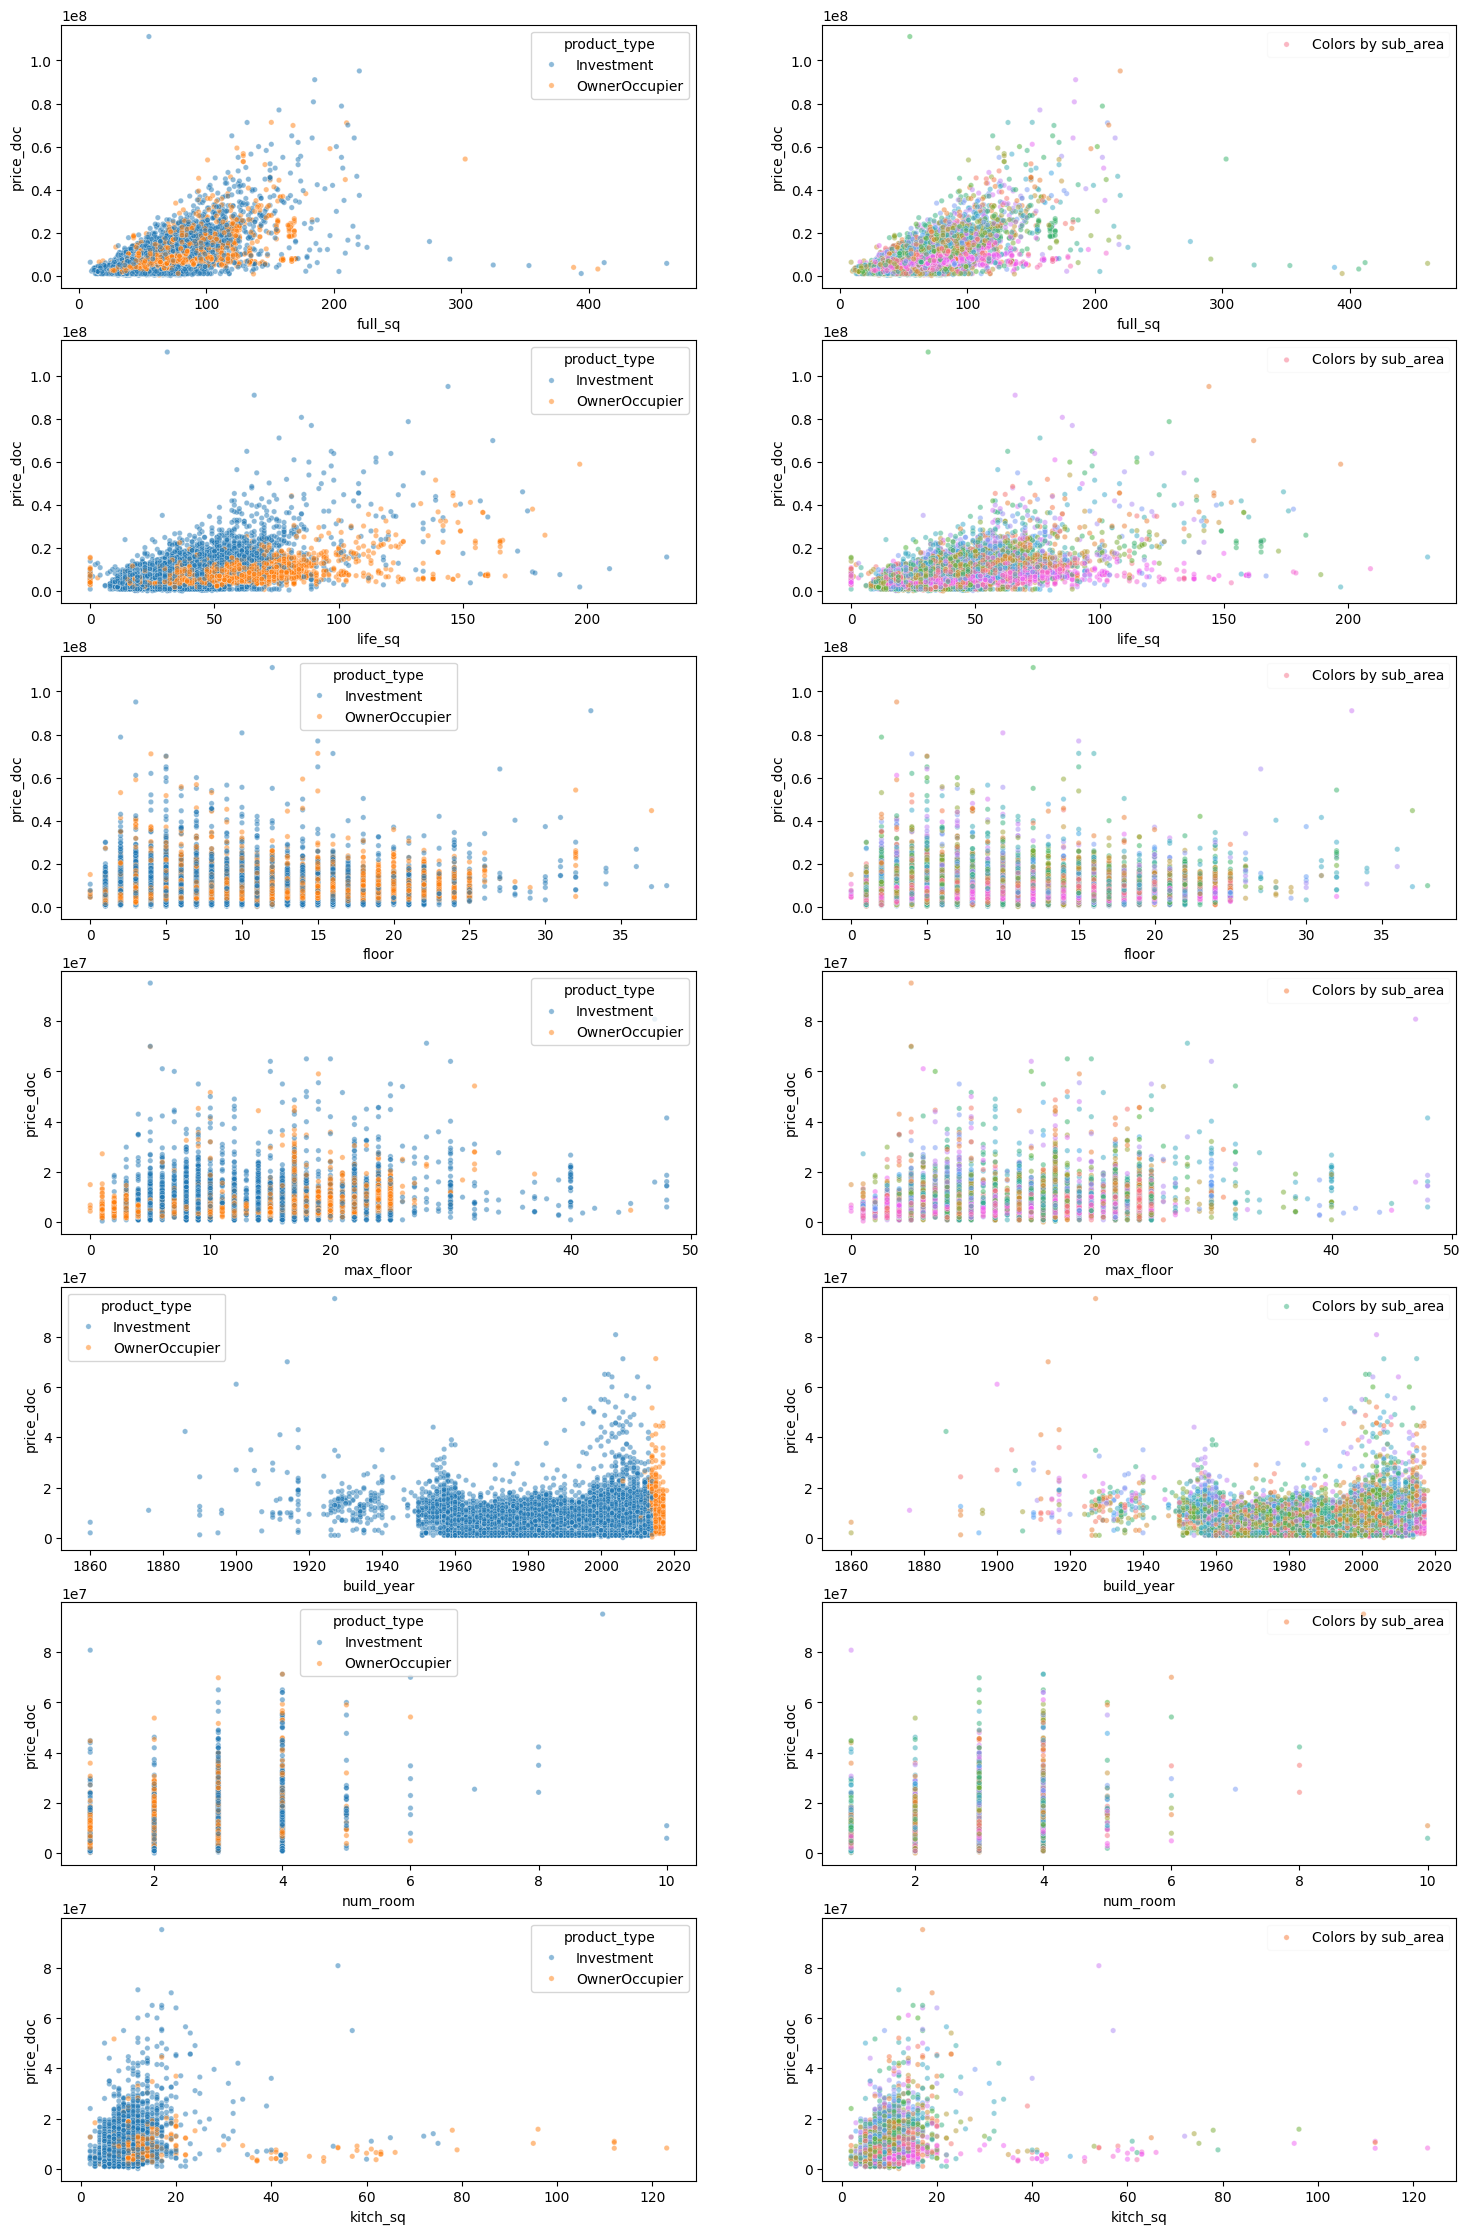

In [10]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(7, 2, figsize=(18, 28))

sns.scatterplot(SbrBkTrain, x = 'full_sq', y = 'price_doc', hue = 'product_type', ax = ax[0, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'full_sq', y = 'price_doc', hue = 'sub_area', ax = ax[0, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'life_sq', y = 'price_doc', hue = 'product_type', ax = ax[1, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'life_sq', y = 'price_doc', hue = 'sub_area', ax = ax[1, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'floor', y = 'price_doc', hue = 'product_type', ax = ax[2, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'floor', y = 'price_doc', hue = 'sub_area', ax = ax[2, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'max_floor', y = 'price_doc', hue = 'product_type', ax = ax[3, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'max_floor', y = 'price_doc', hue = 'sub_area', ax = ax[3, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'build_year', y = 'price_doc', hue = 'product_type', ax = ax[4, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'build_year', y = 'price_doc', hue = 'sub_area', ax = ax[4, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'num_room', y = 'price_doc', hue = 'product_type', ax = ax[5, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'num_room', y = 'price_doc', hue = 'sub_area', ax = ax[5, 1], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'kitch_sq', y = 'price_doc', hue = 'product_type', ax = ax[6, 0], s = 15, alpha = 0.5)
sns.scatterplot(SbrBkTrain, x = 'kitch_sq', y = 'price_doc', hue = 'sub_area', ax = ax[6, 1], s = 15, alpha = 0.5)
ax[0, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[1, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[2, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[3, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[4, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[5, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')
ax[6, 1].legend(['Colors by sub_area'], framealpha = 0.1, loc = 'upper right')

fig.show()  

##### - Missing Values
* Identify missing values in each feature.
* Develop appropriate imputation strategies (mean/median imputation, predictive modeling, or careful removal if justifiable).

In [11]:
(SbrBkTrain.isna().sum() / SbrBkTrain.shape[0] * 100).round(2)

full_sq          0.11
life_sq         22.49
floor            0.56
max_floor       36.33
material        31.41
build_year      47.62
num_room        31.47
kitch_sq        51.97
state           44.50
product_type     0.00
sub_area         0.00
price_doc        0.00
timestamp        0.00
dtype: float64

There are over 50% of the rows in the train data that are missing a value in the kitch_sq column, so its better to drop it

In [12]:
SbrBkTrain.drop(columns = ['kitch_sq'], inplace = True)
SbrBkTest.drop(columns = ['kitch_sq'], inplace = True)

Also, in build_year column and state column there are over 37% of the rows that are missing a value in each column.

I see 37% as the limit to never crossover with missing data, but i still belive these 2 columns are important to the model

I'll try to reduce this precentage by removing all of the rows that are missing a value in both of these 2 columns and at-least 3 more missing values in the same row (5 missing values minimum, roughly half of their features or more are empty)

In [13]:
print(f'There are {((SbrBkTrain.build_year.isna()) & (SbrBkTrain.state.isna()) & (SbrBkTrain.isna().sum(axis = 1) > 4)).sum()} rows with missing values in build_year, state and in at-least 3 other features\nThere are {((SbrBkTrain.build_year.isna()) & (SbrBkTrain.state.isna()) & (SbrBkTrain.isna().sum(axis = 1) > 5)).sum()} rows with missing values in build_year, state and in at-least 4 other features')

There are 9574 rows with missing values in build_year, state and in at-least 3 other features
There are 2407 rows with missing values in build_year, state and in at-least 4 other features


There's another issue with removing these rows, there are just too many of them, almost a third of the rows in the dataset will be removed, this happening really hurts the effectiveness of the modeling in the first place

To handle with this issue I will perform some sort of compromise where i drop all the rows with missing values in build_year, state and in at-least 4 other features (2407 rows), and also a random sample of 3300 other rows that are with missing values in build_year, state and 3 other features (5707 rows in total).

This way, i minimize the dataloss that i would have made if i got rid of all 9574 rows, and also minimize the precentage og missing values that i would need to impute later and with that lower the bias created when imputing such a large amount of missing values.

In [14]:
# marking rows that are certainly supposed to be dropped
SbrBkTrain['toDrop'] = (((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) > 5))
# marking rows that are randomly selected to be dropped
SbrBkTrain.toDrop[rnd.sample(list((((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) == 5))[(((SbrBkTrain.build_year.isna()) | (SbrBkTrain.state.isna())) & (SbrBkTrain.isna().sum(axis = 1) == 5))==True].index), 3300)] = True
# dropping all marked rows
SbrBkTrain = SbrBkTrain[~SbrBkTrain.toDrop]
SbrBkTrain.drop(columns = ['toDrop'], inplace = True)

# viewing the precentages again
(SbrBkTrain.isna().sum() / SbrBkTrain.shape[0] * 100).round(2)

full_sq          0.12
life_sq         18.52
floor            0.01
max_floor       21.65
material        15.62
build_year      35.55
num_room        15.67
state           31.71
product_type     0.00
sub_area         0.00
price_doc        0.00
timestamp        0.00
dtype: float64

Now these ar more acceptable precentages

The rest of the missing values, i would want to impute using the KNNImputer function from sklearn

In [15]:
SbrBkTrain['product_typeCode'] = pd.Categorical(SbrBkTrain.product_type).codes
SbrBkTrain['sub_areaCode'] = pd.Categorical(SbrBkTrain.sub_area).codes

imputedTrainData = KNNImputer(n_neighbors = 20).fit_transform(SbrBkTrain[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode']])
imputedTrain = pd.DataFrame(imputedTrainData, columns = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode'])
imputedTrain.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)
# as observed previously all of the features are integers, and they should remain as such
imputedTrain = imputedTrain.round()
imputedTrain = imputedTrain.set_index(SbrBkTrain.index)
imputedTrain['product_type'] = SbrBkTrain.product_type
imputedTrain['sub_area'] = SbrBkTrain.sub_area
imputedTrain['price_doc'] = SbrBkTrain.price_doc
imputedTrain['timestamp'] = SbrBkTrain.timestamp

In [16]:
imputedTrain.isna().sum()

full_sq         0
life_sq         0
floor           0
max_floor       0
material        0
build_year      0
num_room        0
state           0
product_type    0
sub_area        0
price_doc       0
timestamp       0
dtype: int64

Now in all rows there is no feature that is empty

I'll handle them in the same way in the Test dataset

In [17]:
(SbrBkTest.isna().sum() / SbrBkTest.shape[0] * 100).round(2)

id               0.00
full_sq          0.04
life_sq         19.79
floor            0.01
max_floor        8.39
material         0.00
build_year      20.97
num_room         0.01
state            9.06
product_type     0.43
sub_area         0.00
timestamp        0.00
dtype: float64

In [18]:
SbrBkTest['product_typeCode'] = pd.Categorical(SbrBkTest.product_type).codes
# making sure that the imputation will not miss original Missing values due to technical reasons
SbrBkTest.product_typeCode[SbrBkTest.product_typeCode == -1] = np.nan
SbrBkTest['sub_areaCode'] = pd.Categorical(SbrBkTest.sub_area).codes

imputedTestData = KNNImputer(n_neighbors = 20).fit_transform(SbrBkTest[['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode']])
imputedTest = pd.DataFrame(imputedTestData, columns = ['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'state', 'product_typeCode', 'sub_areaCode'])
# as observed previously all of the features are integers, and they should remain as such
imputedTest = imputedTest.round()
imputedTest = imputedTest.set_index(SbrBkTest.index)
imputedTest['product_type'] = SbrBkTest.product_type
imputedTest['sub_area'] = SbrBkTest.sub_area
imputedTest['id'] = SbrBkTest.id
imputedTest['timestamp'] = SbrBkTest.timestamp
imputedTest.product_type[imputedTest.product_type.isna()] = np.where(imputedTest.product_typeCode[imputedTest.product_type.isna()] == 0, 'Investment', 'OwnerOccupier')
imputedTest.drop(columns = ['product_typeCode', 'sub_areaCode'], inplace = True)

In [19]:
imputedTest.isna().sum()

full_sq         0
life_sq         0
floor           0
max_floor       0
material        0
build_year      0
num_room        0
state           0
product_type    0
sub_area        0
id              0
timestamp       0
dtype: int64

before handling the outliers I want to view the distribution of price_doc

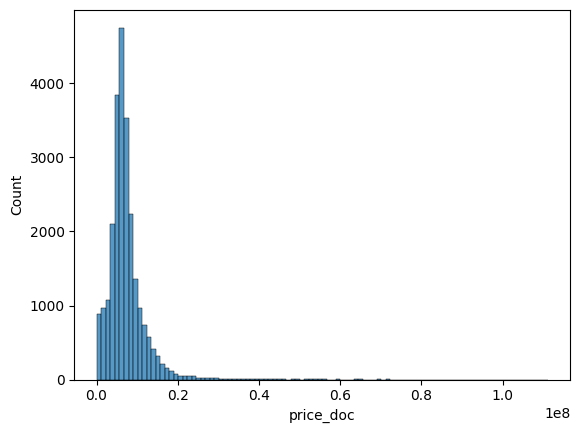

In [20]:
sns.histplot(imputedTrain.price_doc, bins = 100)
plt.show()

this seems very much like a poisson ditribution of some sort, so for better estimation and modeling, i would rather use the log of it as the estimated value (using a link function)

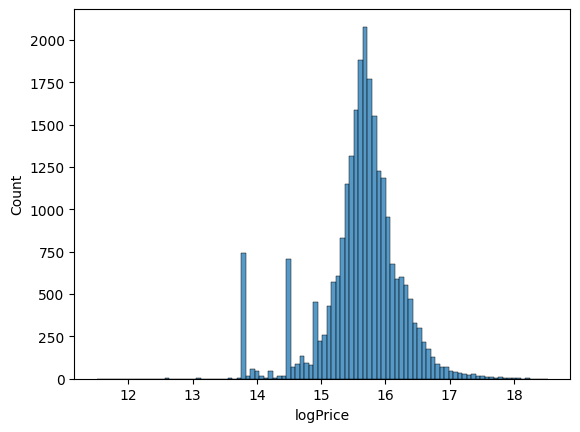

In [21]:
imputedTrain['logPrice'] = np.log(imputedTrain.price_doc)
sns.histplot(imputedTrain.logPrice, bins = 100)
plt.show()

now this seems much more like a normal (gaussian) distribution, with the just a little discrepancy on the left

##### - Outliers
* Use box plots or statistical techniques (e.g., IQR method) to detect potential outliers.

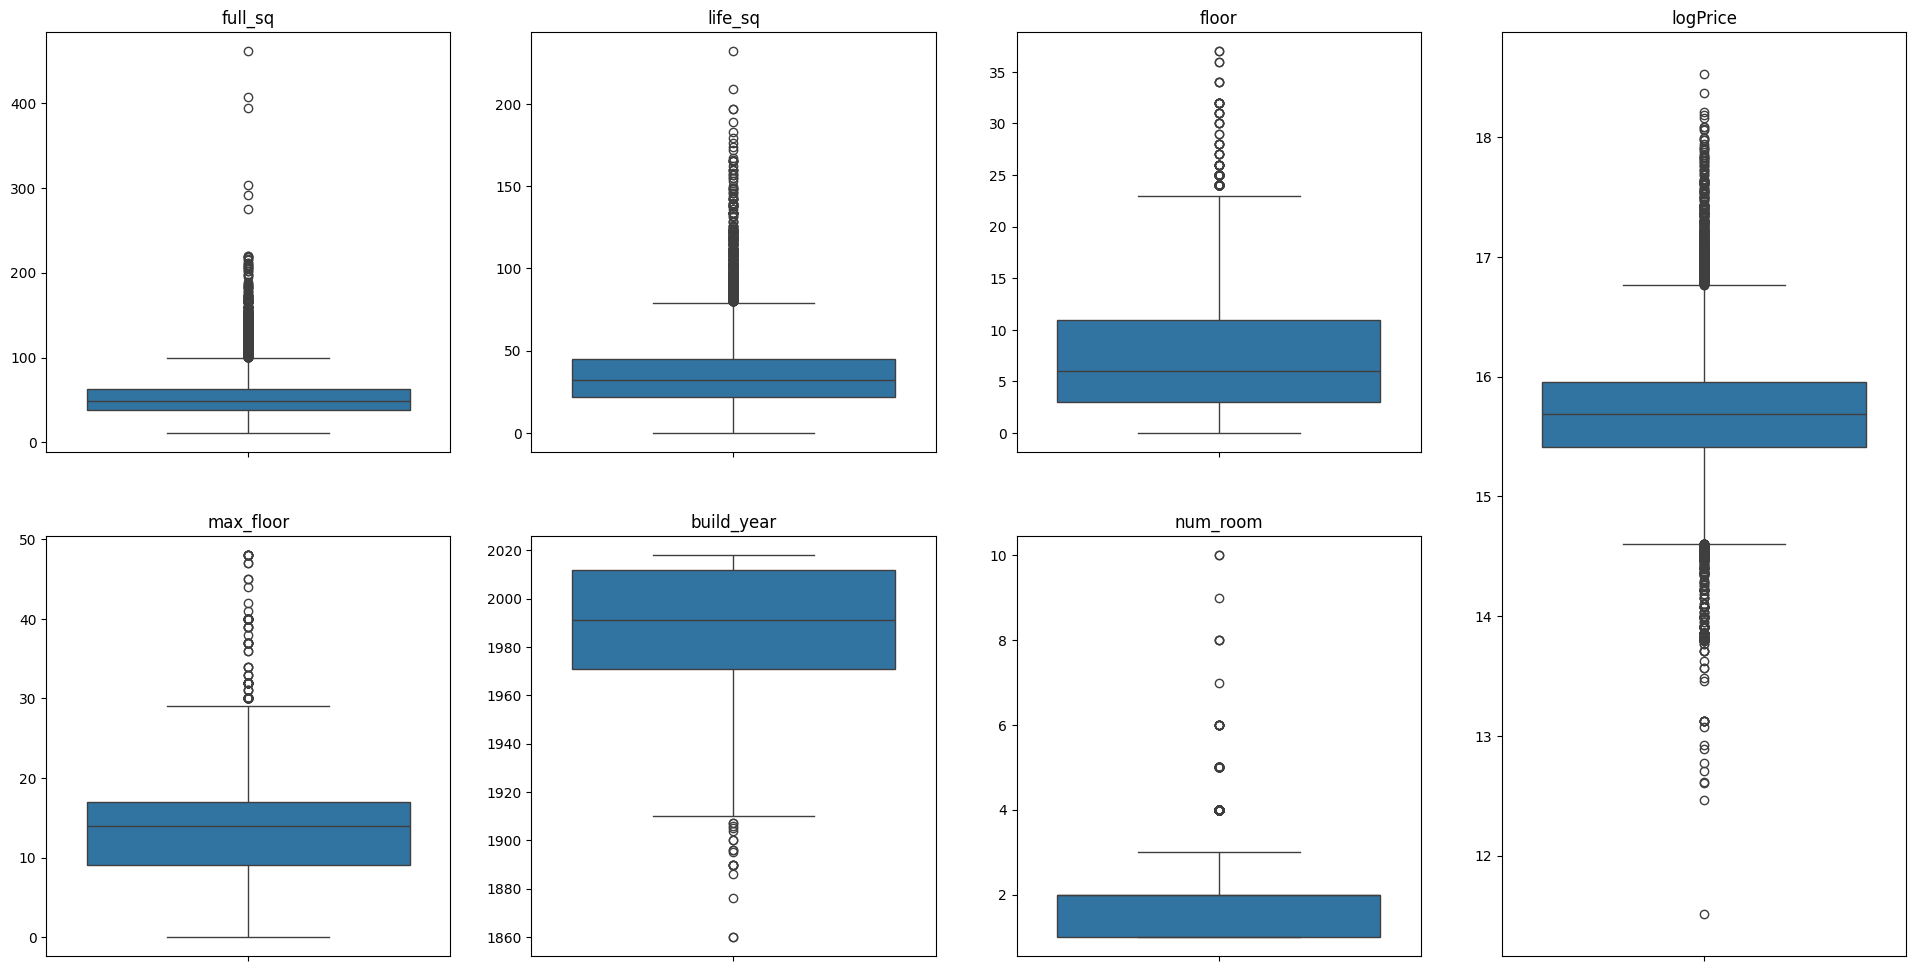

In [22]:
fig = plt.figure(figsize = (24, 12))

gs = grdspc.GridSpec(2, 4)

ax = [None] * 7

for i in range(6):
    ax[i] = fig.add_subplot(gs[i // 3, i%3])
ax[6] = fig.add_subplot(gs[:, 3])

columnsToPlot = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'logPrice']

for i in range(7):
    sns.boxplot(imputedTrain[columnsToPlot[i]], ax = ax[i])
    ax[i].set_title(columnsToPlot[i])
    ax[i].set_ylabel('')

plt.show()

* Consider the impact of outliers and whether to remove, cap, or transform them.

Even tho it seems that removing or handling of the outliers in any other way is helpful in this situation, i think its a waste of the value they bring to the table in accordance to the estimation later, this are the outliers that better define the limits that the final model should be able to get close to and recognise as a possibility

before transforming the data, i prefered to perform the Basic Feature Engineering

### 3. Basic Feature Engineering
##### - Derived Features

* Create new features based on existing ones:
    * Price per square meter (price_doc / full_sq)

        it should be mentioned that creating the Price per square meter feature is not helpful since it could not be created in the test dataset, and aswell incodes withing itself the value that is meant to be estimated, which defeats the whole purpose of estimating.

    * Rooms per square meter (num_room / full_sq)
    * Age of the building (timestamp - build_year)

In [23]:
# requested derived features generation
imputedTrain = imputedTrain.assign(roomPerSq = imputedTrain.num_room / imputedTrain.full_sq,
                                   buildingAge = imputedTrain.timestamp.dt.year - imputedTrain.build_year)
imputedTest = imputedTest.assign(roomPerSq = imputedTest.num_room / imputedTest.full_sq,
                                 buildingAge = imputedTest.timestamp.dt.year - imputedTest.build_year)

##### - Feature Interactions
* Try combining features in meaningful ways (e.g., multiplying or dividing related features to create ratios).

<u>I chose to create the following:</u>

practAging: 

- This feature incompasses the state of the apartment in accordance to its age, or in other words its aging factor, how well did the apartment age, the lower the value the better it aged

- This will be calculated like so: buildingAge / state

roomSize:

- This feature incompasses the average size of any given room in the apartment

- This will be calculated like so: life_sq / num_room

heightScore:

- This feature incompasses how much value does the height of the apartment give to its total value in accordance to the total height of the building, this value will range from 0 to 10, the higher the value the better the height score.

- This will be calculated like so: abs(floor - max_floor * 0.37) / (max_floor * 0.63 / 10)

lifeRatio:

- This feature incompasses how much of the aparatment is dedicated to living area, to avoid the value being too small, this value will range from 0 to 10, the higher the value the more of the apartment is dedicated to living area.

- This will be calculated like so: life_sq / (full_sq / 10)

In [24]:
imputedTrain = imputedTrain.assign(practAging = imputedTrain.buildingAge / imputedTrain.state,
                                   roomSize = imputedTrain.life_sq / imputedTrain.num_room,
                                   heightScore = (imputedTrain.floor - imputedTrain.max_floor * 0.37).abs() / (imputedTrain.max_floor * 0.63 / 10),
                                   lifeRatio = imputedTrain.life_sq / (imputedTrain.full_sq / 10))
imputedTest = imputedTest.assign(practAging = imputedTest.buildingAge / imputedTest.state,
                                 roomSize = imputedTest.life_sq / imputedTest.num_room,
                                 heightScore = (imputedTest.floor - imputedTest.max_floor * 0.37).abs() / (imputedTest.max_floor * 0.63 / 10),
                                 lifeRatio = imputedTest.life_sq / (imputedTest.full_sq / 10))
imputedTrain.heightScore[imputedTrain.heightScore.isna()] = 7
imputedTest.heightScore[imputedTest.heightScore.isna()] = 7

(back to Data Cleaning)
##### - Data Transformation
* Explore one-hot encoding or label encoding for categorical features.

We should take into acount that in the data some of the features are categorical and they should be treated as such, and from that there might be raised some inconsistencies in the values present in the Train dataset and the Test dataset.

I would handle that by creating some common detectable language (a.k.a label dictionary) that would come across the data without creating any data leakage and therefor some bias.

In [25]:
# temporary dataframe to find all the unique values of the categorical features and labeling them apropriately, while also keeping a dictionary to translate it back later on.
imputedUnion = pd.concat([imputedTrain, imputedTest], ignore_index=True)

prodTypeLbl = LabelEncoder().fit(imputedUnion.product_type)
subAreaLbl = LabelEncoder().fit(imputedUnion.sub_area)
mtrlLbl = LabelEncoder().fit(imputedUnion.material)
stateLbl = LabelEncoder().fit(imputedUnion.state)

# replace categorical features with their codes
imputedTrain.product_type = prodTypeLbl.transform(imputedTrain.product_type)
imputedTest.product_type = prodTypeLbl.transform(imputedTest.product_type)
imputedTrain.sub_area = subAreaLbl.transform(imputedTrain.sub_area)
imputedTest.sub_area = subAreaLbl.transform(imputedTest.sub_area)
imputedTrain.material = mtrlLbl.transform(imputedTrain.material)
imputedTest.material = mtrlLbl.transform(imputedTest.material)
imputedTrain.state = stateLbl.transform(imputedTrain.state)
imputedTest.state = stateLbl.transform(imputedTest.state)

* Apply normalization or scaling to numerical features if required by certain models.

Some of the numerical values are very large in theire value

This could become an issue for understanding the results later on and might even cause issue with the estimation due to computation limitations

To solve that I will perform some rescaling of the values, each feature in respect to itself

><u>full_sq:</u>
>
> The values of this feature ranges from 0 to 500, I would rather them to range from 0 to 100 but not change theire dispersion, meaning I should divide all of the values of this feature with the largest value this feature has and multiply the results by 100

><u>life_sq:</u>
>
> The values of this feature ranges from 0 to 300, I would rather them to range from 0 to 100 but not change theire dispersion, meaning I should divide all of the values of this feature with the largest value this feature has and multiply the results by 100

><u>floor:</u>
>
> The values of this feature I would rather to keep as they are since the are not to large or to small to handle

><u>max_floor:</u>
>
> The values of this feature I would rather to keep as they are since the are not to large or to small to handle

><u>build_year:</u>
>
> The values of this feature ranges from 1860 to 2020, I would rather them to start from 0 and continue as they are in theire dispersion, therefore i need to subtract from all of the values the smallest value this feature has

><u>num_room:</u>
>
> The values of this feature I would rather to keep as they are since the are not to large or to small to handle

In [26]:
# Rescaling full_sq in imputedTrain and impuedTest
scaledMaxFullSq = imputedUnion.full_sq.max() / 100
imputedTrain.full_sq = imputedTrain.full_sq / scaledMaxFullSq
imputedTest.full_sq = imputedTest.full_sq / scaledMaxFullSq

# Rescaling life_sq in imputedTrain and impuedTest
scaledMaxLifeSq = imputedUnion.life_sq.max() / 100
imputedTrain.life_sq = imputedTrain.life_sq / scaledMaxLifeSq
imputedTest.life_sq = imputedTest.life_sq / scaledMaxLifeSq

# Rescaling build_year in imputedTrain and impuedTest
minBuildYear = imputedUnion.build_year.min()
imputedTrain.build_year = imputedTrain.build_year - minBuildYear
imputedTest.build_year = imputedTest.build_year - minBuildYear

### 4. Acounting for Price Changes over Time
##### - Analyze Temporal Trend: Plot sale prices over time to visualize any trends or seasonality.

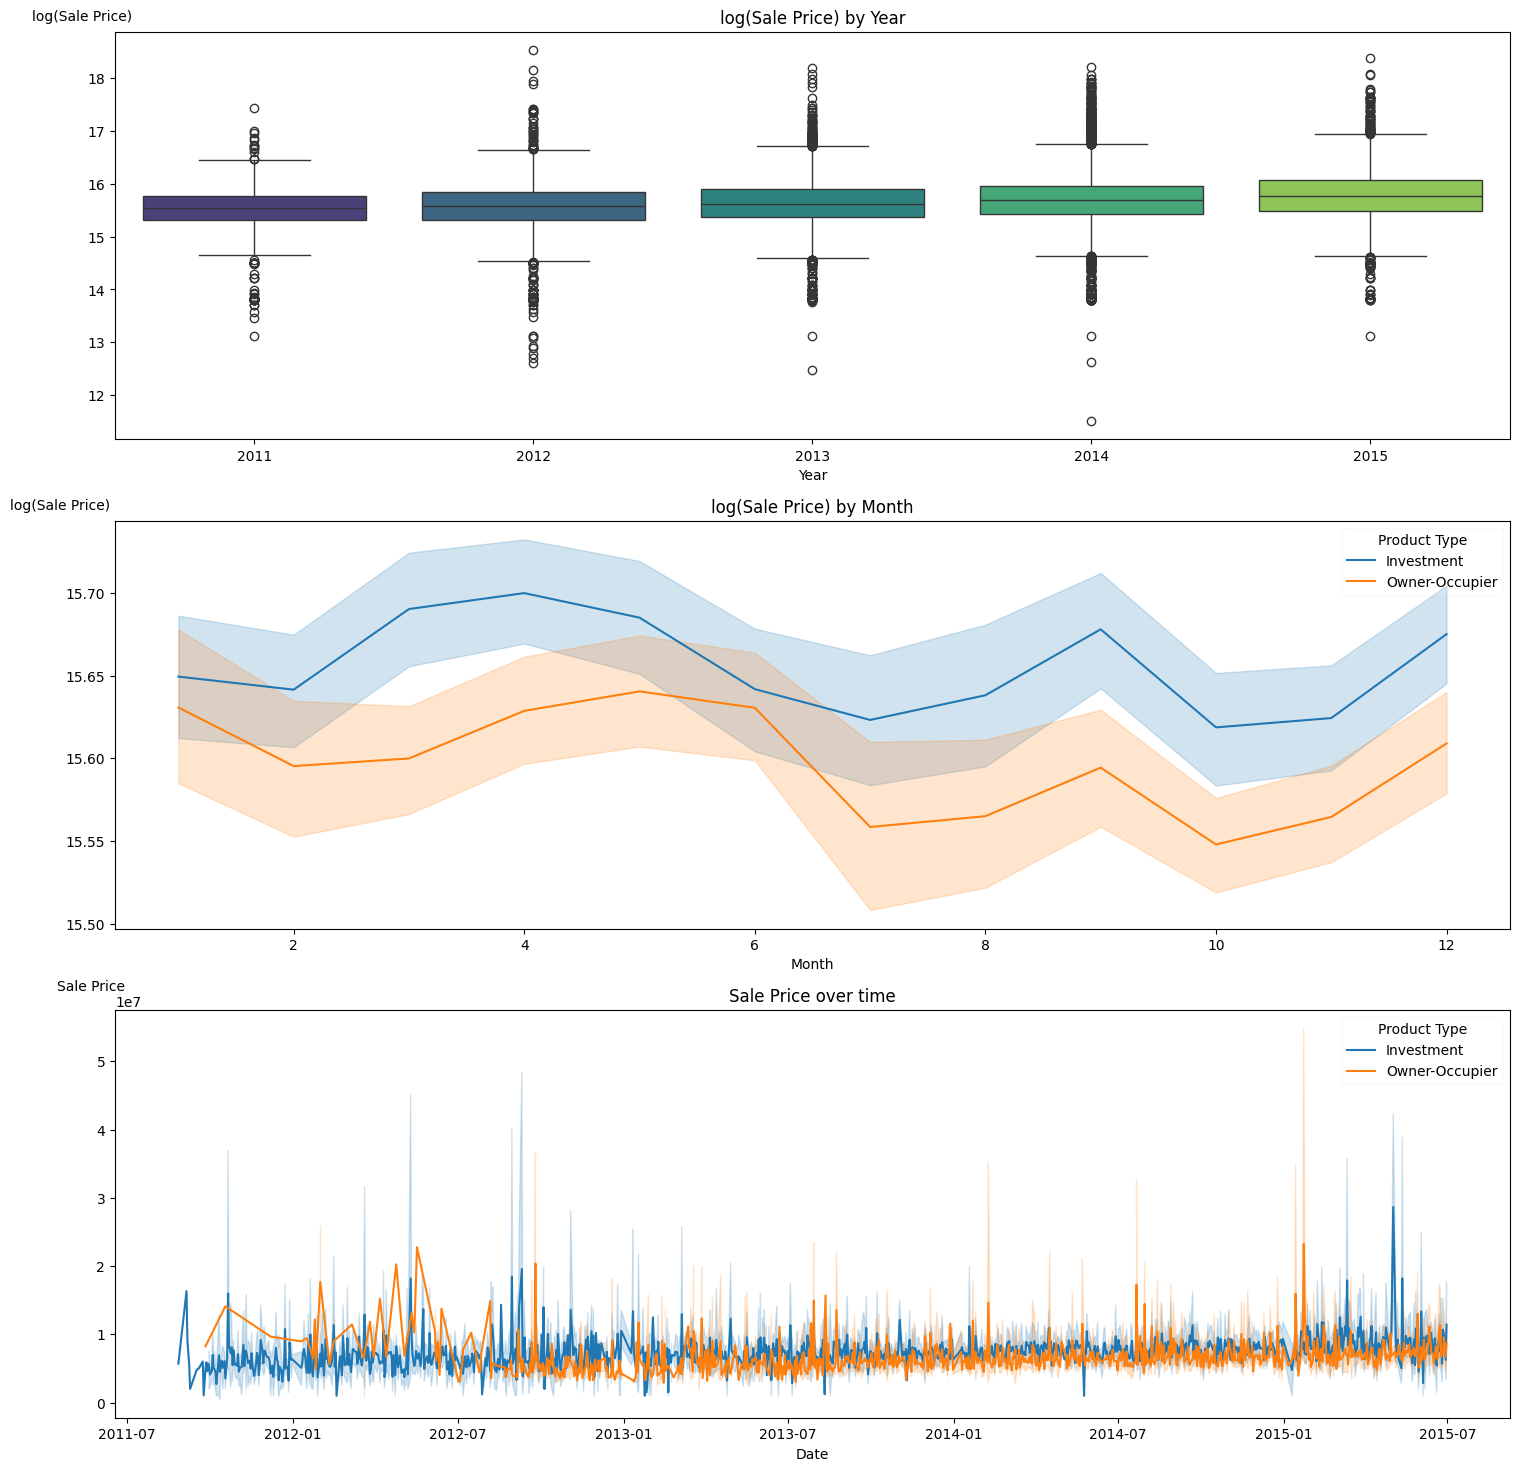

In [27]:
fig, ax = plt.subplots(3, figsize = (18, 18))

sns.boxplot(y = 'logPrice', x = imputedTrain.timestamp.dt.year.astype('category'), data = imputedTrain, ax = ax[0], palette = sns.color_palette('viridis', n_colors = imputedTrain.timestamp.dt.year.nunique()))
sns.lineplot(y = 'logPrice', x = imputedTrain.timestamp.dt.month, data = imputedTrain, ax = ax[1], hue = 'product_type')
sns.lineplot(y = 'price_doc', x = 'timestamp', data = imputedTrain, ax = ax[2], hue = 'product_type')

ax[0].set_title('log(Sale Price) by Year')
ylabel0 = ax[0].set_ylabel('log(Sale Price)')
ylabel0.set_rotation(0)
ylabel0.set_position((0, 1.02))
ax[0].set_xlabel('Year')
ax[1].set_title('log(Sale Price) by Month')
ylabel1 = ax[1].set_ylabel('log(Sale Price)')
ylabel1.set_rotation(0)
ylabel1.set_position((0, 1.02))
ax[1].set_xlabel('Month')
ax[1].legend(ax[1].get_legend().get_lines(),['Investment', 'Owner-Occupier'], title = 'Product Type', framealpha = 0.1, loc = 'upper right')
ax[2].set_title('Sale Price over time')
ylabel2 = ax[2].set_ylabel('Sale Price')
ylabel2.set_rotation(0)
ylabel2.set_position((0, 1.04))
ax[2].set_xlabel('Date')
ax[2].legend(ax[2].get_legend().get_lines(),['Investment', 'Owner-Occupier'], title = 'Product Type', framealpha = 0.1, loc = 'upper right')

fig.show()

##### - Choose the data manipulation to deal with the temporal aspects of the dataset

As has been viewed and mentioned before price_doc seem to be poisson distributed, and to better represent it and its distribution i have performed log on price_doc

Other than that i dont see any-other transformation or manipulation to do to deal with the temporal aspects but to add the months as feature

In [28]:
imputedTrain['month'] = imputedTrain.timestamp.dt.month
imputedTest['month'] = imputedTest.timestamp.dt.month

### 5. Baseline Model Development and Evaluation
##### - Split Data: Divide your dataset into training, validation, and testing sets (use an appropriate ratio like 70/15/15).

In [29]:
finalTrain = imputedTrain.copy(deep = True).reset_index(drop = True)
finalTest = imputedTest.copy(deep = True).reset_index(drop = True)

# due to it being a time series it is only appropriate to split the data in a chronological manner
TrainData = finalTrain.loc[:int(finalTrain.shape[0] * 0.7), :]
xTrn = TrainData.drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yTrn = TrainData.logPrice
ValidationData = finalTrain.loc[int(finalTrain.shape[0] * 0.7): int(finalTrain.shape[0] * 0.85), :]
xVal = ValidationData.drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yVal = ValidationData.logPrice
TestData = finalTrain.loc[int(finalTrain.shape[0] * 0.85):, :]
xTst = TestData.drop(columns = ['price_doc', 'logPrice', 'timestamp'])
yTst = TestData.logPrice

##### - Random Forest Model
* Instantiate a RandomForestRegressor
* Feature Selection:
    * Use feature importance to identify the most important features.
    * Decide on the optimal number of features for the dataset

In [30]:
ftrSlctModel = RFR(n_jobs = -1, random_state = 42)
ftrSlctModel.fit(xTrn, yTrn)
imprtnc = ftrSlctModel.feature_importances_
features = pd.Series(imprtnc, index = xTrn.columns).sort_values(ascending = False)
features = list(features[features > 0.05].index)
features

['full_sq',
 'sub_area',
 'lifeRatio',
 'heightScore',
 'month',
 'practAging',
 'build_year',
 'buildingAge']

In [31]:
rndFrstBaseModel = RFR()

rndFrstParams = {
    'max_depth': [i for i in range(4, 9, 2)],
    'n_estimators': [i for i in range(100, 301, 50)],
    'min_samples_leaf': [i for i in range(3, 10, 3)]
}

* Train the model on the training set.

In [32]:
grdSrcRndFrst = GSCV(rndFrstBaseModel, rndFrstParams, cv = 5, scoring = 'neg_mean_squared_error')
grdSrcRndFrst.fit(xTrn[features], yTrn)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [3, 6, 9],
                         'n_estimators': [100, 150, 200, 250, 300]},
             scoring='neg_mean_squared_error')

In [33]:
RndFrstModelParams = grdSrcRndFrst.best_params_

rndFrstOptModel = RFR(**RndFrstModelParams)
rndFrstOptModel.fit(xTrn[features], yTrn)

RandomForestRegressor(max_depth=8, min_samples_leaf=9, n_estimators=250)

* Calculate MSE on validation set using 5-Fold Cross-Validation

In [34]:
rndFrstMseScores = -1 * CVS(rndFrstOptModel, xVal[features], yVal, cv = 5, scoring = 'neg_mean_squared_error')

print(f'The mean squared error of the model on the validation set is {rndFrstMseScores.mean()}')

The mean squared error of the model on the validation set is 0.21057536435131102


Also done on the test set because it has not been used further on.

I do acknowledge that in practice you use the validation set first and when the validation satisfys me i use the test set.

In [35]:
rndFrstMseScores = -1 * CVS(rndFrstOptModel, xTst[features], yTst, cv = 5, scoring = 'neg_mean_squared_error')

print(f'The mean squared error of the model on the Test set is {rndFrstMseScores.mean()}')

The mean squared error of the model on the Test set is 0.1938298813569083


##### - XGBoost Model
* Instantiate an XGBoostRegressor

    There is no XGBoostRegerssor in sklearn, i used GradientBoostingRegressor instead as it was used in the files of the lab class

In [36]:
xTrn.isna().sum()

full_sq         0
life_sq         0
floor           0
max_floor       0
material        0
build_year      0
num_room        0
state           0
product_type    0
sub_area        0
roomPerSq       0
buildingAge     0
practAging      0
roomSize        0
heightScore     0
lifeRatio       0
month           0
dtype: int64

* Hyperparameter Tuning
    * Use techniques like GridSearchCV or RandomizedSearchCV to optimize hyperparameters (e.g., learning rate, max_depth, n_estimators)

In [37]:
xgbBaseModel = GBR()

xgbParams = {
    'learning_rate': [i/1000 for i in range(6, 15, 4)],
    'n_estimators': [i for i in range(100, 301, 100)],
    'subsample': [i/20 for i in range(13, 18, 2)],
    'max_depth': [i for i in range(4, 9, 2)],
    'min_samples_leaf': [i for i in range(3, 18, 7)]
}

In [38]:
grdSrcXgb = GSCV(xgbBaseModel, xgbParams, cv = 5, scoring = 'neg_mean_squared_error')
grdSrcXgb.fit(xTrn, yTrn)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.006, 0.01, 0.014],
                         'max_depth': [4, 6, 8],
                         'min_samples_leaf': [3, 10, 17],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.65, 0.75, 0.85]},
             scoring='neg_mean_squared_error')

* Train the model on the training set.

In [39]:
xgbModelParams = grdSrcXgb.best_params_

xgbOptModel = GBR(**xgbModelParams)
xgbOptModel.fit(xTrn, yTrn)

GradientBoostingRegressor(learning_rate=0.014, max_depth=8, min_samples_leaf=17,
                          n_estimators=300, subsample=0.75)

* Calculate MSE on validation set using 5-Fold Cross-Validation.

In [40]:
xgbMseScores = -1 * CVS(xgbOptModel, xVal, yVal, cv = 5, scoring = 'neg_mean_squared_error')

print(f'The mean squared error of the model on the validation set is {xgbMseScores.mean()}')

The mean squared error of the model on the validation set is 0.2043378092759242


Also done on the test set here as well for the same reason.

In [41]:
xgbMseScores = -1 * CVS(xgbOptModel, xTst, yTst, cv = 5, scoring = 'neg_mean_squared_error')

print(f'The mean squared error of the model on the Test set is {xgbMseScores.mean()}')

The mean squared error of the model on the Test set is 0.1826294122035275


### 6. Kaggle Submission and Evaluation
##### - Prediction: Generate predictions on the Kaggle competition's test set using both of your trained models.
##### - Submission Format: Adhere to Kaggle's submission file format requirements.
##### - Submit and Score: Submit each prediction file and obtain your leaderboard scores.

In [42]:
# export random forest model
yPredRndFrst = np.round(np.exp(rndFrstOptModel.predict(finalTest[features])), decimals = -3)
rndFrstSubmission = pd.DataFrame({'id': finalTest.id, 'price_doc': yPredRndFrst})
rndFrstSubmission.to_csv('RandomForestSubmission.csv', index = False)


# export xgboost model
yPredXgb = np.round(np.exp(xgbOptModel.predict(finalTest[[col for col in finalTest.columns if col not in ['id', 'timestamp']]])), decimals = -3)
xgbSubmission = pd.DataFrame({'id': finalTest.id, 'price_doc': yPredXgb})
xgbSubmission.to_csv('XGBoostSubmission.csv', index = False)